# Data Loading

In [28]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA , TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

import time
# Classifier Librarises
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import warnings
warnings.filterwarnings('ignore')

# utils



In [2]:
data_dir_path = '../data'
filename_train = 'train_data.txt'
filename_test = 'test_data.txt'
filename_labels_test = 'answer.txt'

In [38]:

data_train = pd.read_csv(os.path.join(data_dir_path,filename_train),sep = ",", header = None)
original_X_test = pd.read_csv(os.path.join(data_dir_path,filename_test),sep=",",header = None)
original_Y_test = pd.read_csv(os.path.join(data_dir_path,filename_labels_test),header=None)
original_Y_train = data_train.iloc[:,-1]
original_X_train = data_train.drop(data_train.columns[-1],axis=1)  


#### 检测训练集，测试集里面 类的占比

In [4]:
# 检查被标记为有风险（1）的比例
print("训练集中有风险的比例：{}".format(original_Y_train.value_counts()[1]/len(original_Y_train)))
print("训练集中无风险的比例：{}".format(original_Y_train.value_counts()[0]/len(original_Y_train)))
print()
print("测试集中有风险的比例：{}".format(original_Y_test.value_counts()[1]/len(original_Y_test)))
print("测试集中无风险的比例：{}".format(original_Y_test.value_counts()[0]/len(original_Y_test)))

训练集中有风险的比例：0.368625
训练集中无风险的比例：0.631375

测试集中有风险的比例：0.31315657828914456
测试集中无风险的比例：0.6868434217108554


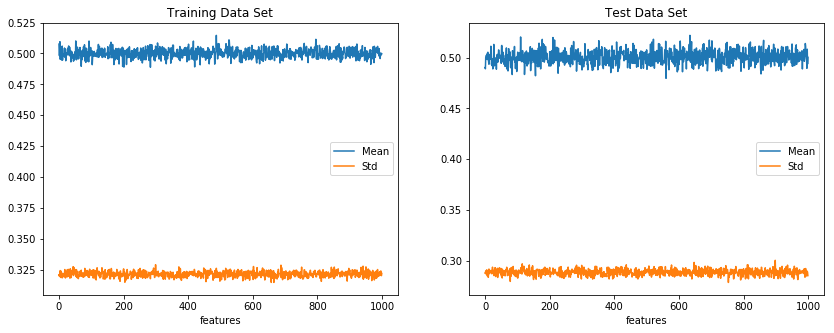

In [5]:
# 检查 各列数据是否已经完全标准化, 图例 表明每一个维度都已经标准化
fig, axs = plt.subplots(1,2,figsize=(14,5))
axs[0].plot(original_X_train.mean(),label='Mean')
axs[0].plot(original_X_train.std(),label='Std')
axs[0].set_title("Training Data Set")
axs[0].set_xlabel("features")
axs[0].legend()

axs[1].plot(original_X_test.mean(),label='Mean')
axs[1].plot(original_X_test.std(),label='Std')
axs[1].set_title("Test Data Set")
axs[1].set_xlabel("features")
axs[1].legend()
plt.show()

In [6]:
std_scaler = StandardScaler()


# the the doc of TSNE suggests, we would like to firstly
#reduce the dimenstions of the original data to 40 with PCA
start_time = time.time()
X_train_PCA = PCA(n_components=50,random_state=40).fit_transform(
    std_scaler.fit_transform(original_X_train.values))
print("PCA took: {:4.2f}s".format(time.time()-start_time))
start_time = time.time()
X_train_tsne = TSNE(n_components=2,
                    random_state=40,
                    perplexity=10,
                    learning_rate=30,
                    n_iter=5000).fit_transform(X_train_PCA)
print("t-SNE took: {:4.2f}s".format(time.time()-start_time))

PCA took: 0.44s
t-SNE took: 241.30s


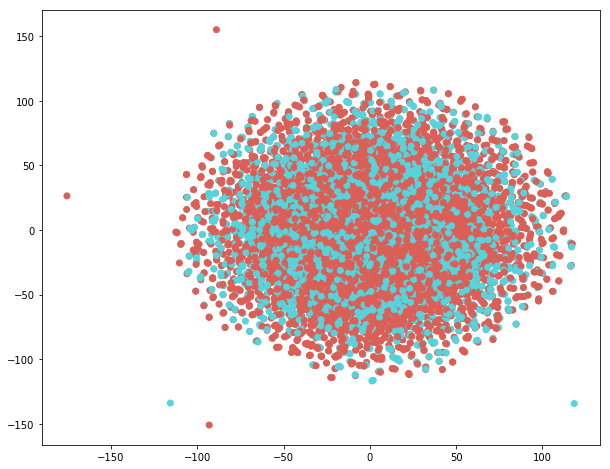

In [8]:
figure = plt.figure(figsize=(10,8))
palette = np.array(sns.color_palette("hls",2))
# ax = plt.axes(projection = '3d')
# # t-SNE scatter plot
# ax.scatter3D(X_train_tsne[:,0], X_train_tsne[:,1], X_train_tsne[:,2], 
#              c=(original_Y_train.values==1) ,cmap='coolwarm');

plt.scatter(X_train_tsne[:,0],
            X_train_tsne[:,1],
            c=palette[original_Y_train.values.astype(np.int)],)


plt.show()

In [9]:
# X_train,X_val,Y_train,Y_val = train_test_split(original_X_train.values,
#                                                original_Y_train.values,
#                                                test_size=0.2,
#                                                random_state=12)

In [10]:
classifiers = {
    "LogisticRegression": LogisticRegression(solver='sag'),
    "KNeighborsClassifier":KNeighborsClassifier(),
    "Support Vectro classifier": SVC(gamma='scale'),
    "DecisionTreeClassifier": DecisionTreeClassifier()
}

In [13]:
from sklearn.model_selection import cross_val_score


for key, classifier in classifiers.items():
#     classifier.fit(X_train, Y_train)
    training_score = cross_val_score(classifier, original_X_train.values, original_Y_train.values, cv=5,n_jobs=-1)
    print("Classifiers: ", classifier.__class__.__name__, "Has a training score of", round(training_score.mean(), 2) * 100, "% accuracy score")

Classifiers:  LogisticRegression Has a training score of 74.0 % accuracy score
Classifiers:  KNeighborsClassifier Has a training score of 59.0 % accuracy score
Classifiers:  SVC Has a training score of 75.0 % accuracy score
Classifiers:  DecisionTreeClassifier Has a training score of 53.0 % accuracy score


In [39]:
X_train = original_X_train.values
Y_train = original_Y_train.values
X_test = original_X_test.values
Y_test = original_Y_test.values

In [27]:
from sklearn.model_selection import GridSearchCV


# Logistic Regression 
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}



grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params,cv=5,n_jobs=-1)
grid_log_reg.fit(X_train, Y_train)
print("Logistic Regression best score: {:4.2f}%".format(grid_log_reg.best_score_*100))
# We automatically get the logistic regression with the best parameters.
log_reg = grid_log_reg.best_estimator_

knears_params = {"n_neighbors": list(range(3,10,2)), 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

grid_knears = GridSearchCV(KNeighborsClassifier(), knears_params,cv=5,n_jobs=-1)
grid_knears.fit(X_train, Y_train)
# KNears best estimator
knears_neighbors = grid_knears.best_estimator_
print("KNN best score: {:4.2f}%".format(grid_knears.best_score_*100))

# Support Vector Classifier
svc_params = {'C': [0.5, 0.7, 0.9, 1], 'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}
grid_svc = GridSearchCV(SVC(), svc_params,cv=5,n_jobs=-1)
grid_svc.fit(X_train, Y_train)

# SVC best estimator
svc = grid_svc.best_estimator_
print("SVC best score: {:4.2f}%".format(grid_svc.best_score_*100))

# DecisionTree Classifier
tree_params = {"criterion": ["gini", "entropy"], "max_depth": list(range(2,4,1)), 
              "min_samples_leaf": list(range(5,7,1))}
grid_tree = GridSearchCV(DecisionTreeClassifier(), tree_params,cv=5,n_jobs=-1)
grid_tree.fit(X_train, Y_train)

# tree best estimator
tree_clf = grid_tree.best_estimator_
print("Decision Tree best score: {:4.2f}%".format(grid_tree.best_score_*100))

Logistic Regression best score: 74.65%
KNN best score: 60.56%
SVC best score: 75.19%
Decision Tree best score: 63.06%


In [44]:
confusion_matrix(Y_train,svc.predict(X_train))


array([[4552,  499],
       [ 726, 2223]])

In [40]:
Y_test.shape

(2000, 1)

In [42]:
(1224+477)/(1224+150+149+477)

0.8505